# Imports and files

In [1]:
from pathlib import Path

import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from PIL import Image
from utils import celltype_signatures

from sainsc import read_StereoSeq

In [2]:
data_path = Path("data") / "StereoSeq"
analysis_path = Path("embryo")

stereo_seq_file_embryo = data_path / "E16.5_E1S3_GEM_bin1.tsv.gz"

# Gene signatures
SVG_file = analysis_path / "MoranI_bin50.csv"

SVG_signature_file = analysis_path / "SVG_signatures.csv"

In [4]:
analysis_path.mkdir(exist_ok=True, parents=True)

# Determine usable area

This is probably easier done while reading the file binned which is much faster

In [3]:
embryo = read_StereoSeq(stereo_seq_file_embryo, n_threads=16)

print(embryo)

LazyKDE (16 threads)
    genes: 28633
    shape: (44100, 26460)
    resolution: 500.0 nm / px


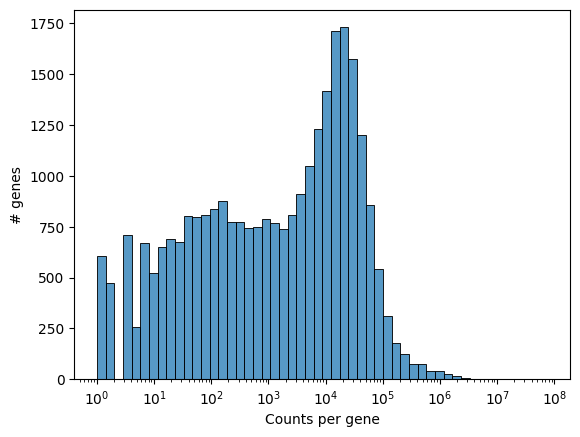

In [4]:
_ = embryo.plot_genecount_histogram()

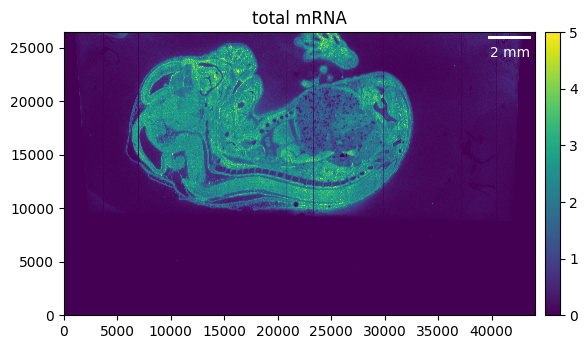

In [5]:
embryo.calculate_total_mRNA()

_ = embryo.plot_genecount(im_kwargs={"vmax": 5})

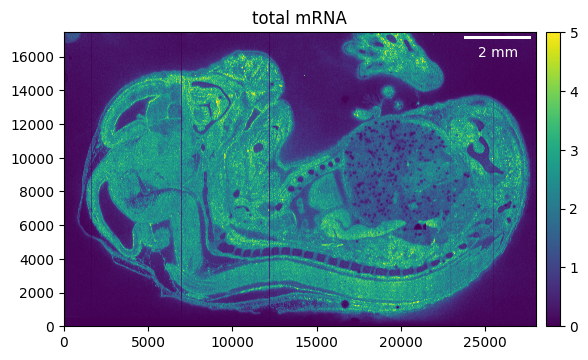

In [6]:
coords = ((5_000, 33_000), (9_000, None))

embryo.counts.crop(*coords)

embryo.calculate_total_mRNA()

_ = embryo.plot_genecount(im_kwargs={"vmax": 5})

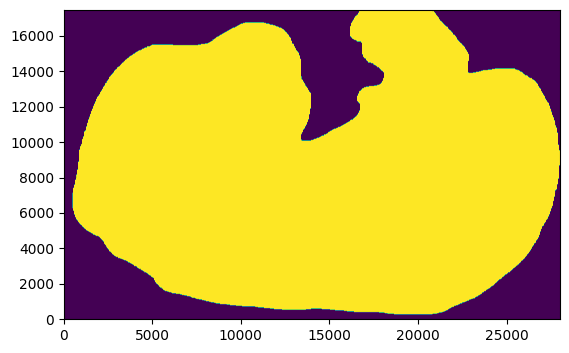

In [7]:
# avoid the DecompressionBombError
Image.MAX_IMAGE_PIXELS = None

embryo_mask = np.array(Image.open(analysis_path / "embryo_selection.png")).astype(bool)

_ = plt.imshow(embryo_mask.T, origin="lower")

In [8]:
embryo.counts.filter_mask(embryo_mask)

In [9]:
# drop empty genes
ngenes_prior = len(embryo.genes)

embryo.counts.filter_genes_by_count(min=1)

print(f"Dropped {ngenes_prior-len(embryo.genes)} genes")

Dropped 75 genes


In [10]:
embryo.gaussian_kernel(8)

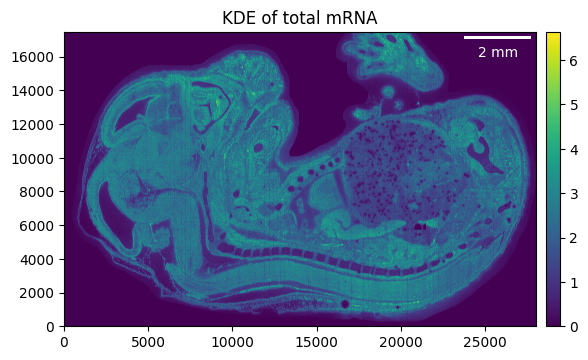

In [11]:
embryo.calculate_total_mRNA()
embryo.calculate_total_mRNA_KDE()

_ = embryo.plot_KDE()

# Find celltype signatures

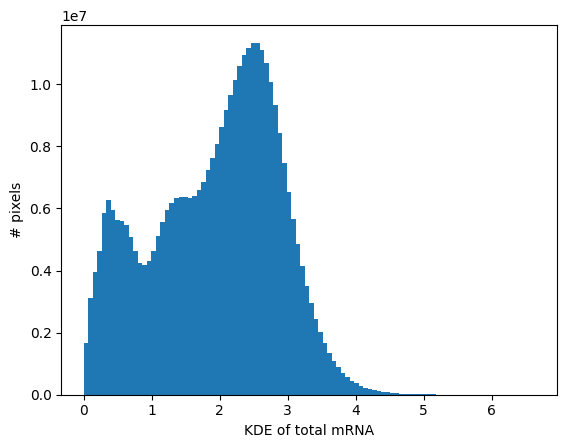

In [12]:
_ = embryo.plot_KDE_histogram(bins=100)

In [13]:
embryo.filter_background(0.9)

In [14]:
embryo.find_local_maxima(4, min_area=60)

In [16]:
print(embryo)

LazyKDE (16 threads)
    genes: 28558
    shape: (28000, 17460)
    resolution: 500.0 nm / px
    kernel: (33, 33)
    background: set
    local maxima: 217728


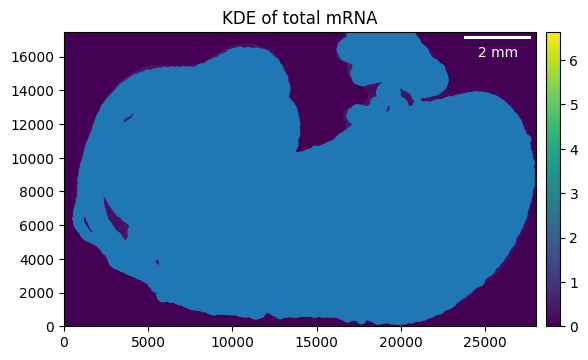

In [17]:
_ = embryo.plot_local_maxima()

## SVG

In [18]:
svg_genes = pd.read_csv(SVG_file)["gene"].to_list()

len(svg_genes)

2000

In [19]:
cellproxy_adata = embryo.load_local_maxima(svg_genes)

print(cellproxy_adata)

AnnData object with n_obs × n_vars = 217728 × 2000
    obsm: 'spatial'


In [20]:
sc.pp.normalize_total(cellproxy_adata)

In [21]:
sc.pp.log1p(cellproxy_adata)

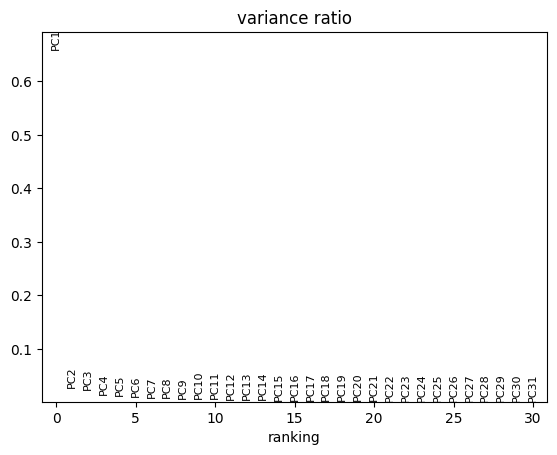

In [22]:
sc.pp.pca(cellproxy_adata)

sc.pl.pca_variance_ratio(cellproxy_adata)

In [23]:
sc.pp.neighbors(cellproxy_adata)

/dh-projects/ag-ishaque/analysis/muellni/envs/sainsc/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


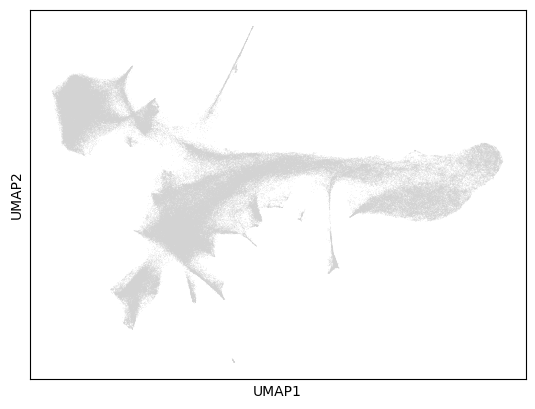

In [32]:
sc.tl.umap(cellproxy_adata, min_dist=0.1)

sc.pl.umap(cellproxy_adata)

/tmp/ipykernel_2380713/1156120607.py:4: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(cellproxy_adata, resolution=resolution, key_added=name)


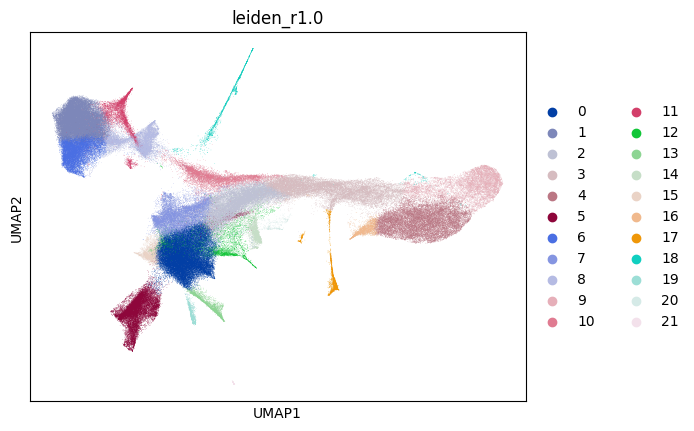

In [33]:
resolution = 1
name = f"leiden_r{resolution:.1f}"

sc.tl.leiden(cellproxy_adata, resolution=resolution, key_added=name)

sc.pl.umap(cellproxy_adata, color=name)

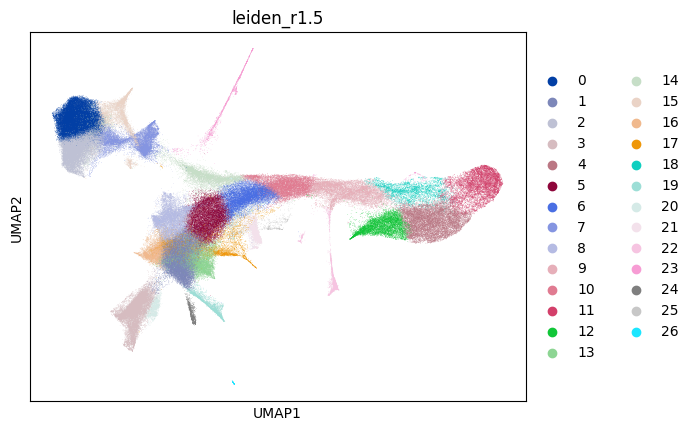

In [34]:
resolution = 1.5
name = f"leiden_r{resolution:.1f}"

sc.tl.leiden(cellproxy_adata, resolution=resolution, key_added=name)

sc.pl.umap(cellproxy_adata, color=name)

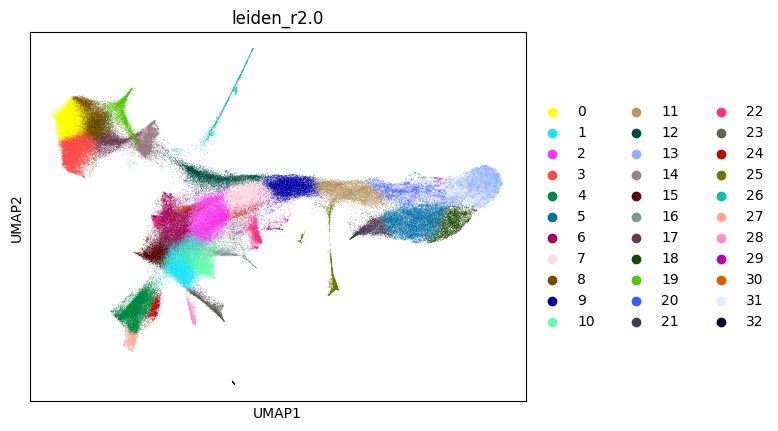

In [35]:
resolution = 2
name = f"leiden_r{resolution:.1f}"

sc.tl.leiden(cellproxy_adata, resolution=resolution, key_added=name)

sc.pl.umap(cellproxy_adata, color=name)

In [36]:
cellproxy_adata.write_h5ad(analysis_path / "cellproxy_unsupervised_SVG.h5ad")

In [37]:
signatures_from_clustering = celltype_signatures(
    cellproxy_adata, celltype_col="leiden_r2.0", agg_method="mean"
)

signatures_from_clustering.to_csv(SVG_signature_file)

# Celltype map

In [46]:
signatures = pd.read_csv(SVG_signature_file, index_col=0)

signatures.shape

(2000, 27)

In [47]:
embryo.assign_celltype(signatures, log=True)

print(embryo)

LazyKDE (16 threads)
    genes: 28558
    shape: (28000, 17460)
    resolution: 500.0 nm / px
    kernel: (33, 33)
    background: set
    local maxima: 217728
    celltypes: 27


In [ ]:
import pickle

with open(analysis_path / "embryo_unsupervised_resolution2.pickle", mode="wb") as out:
    pickle.dump(embryo, out)

In [4]:
import colorcet as cc

cmap = dict(
    zip(embryo.celltypes, sns.color_palette(cc.glasbey, n_colors=len(embryo.celltypes)))
)

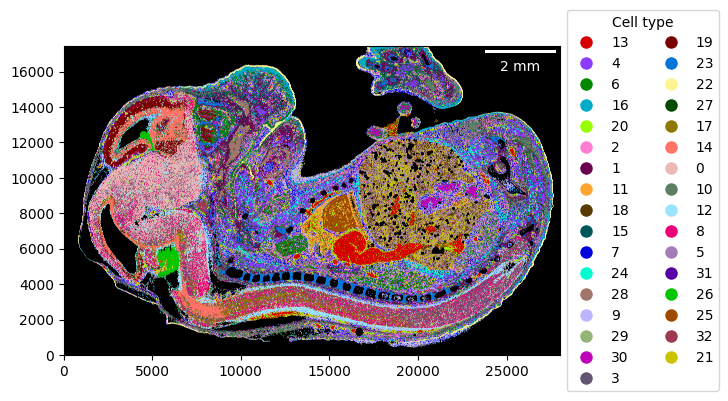

In [42]:
_ = embryo.plot_celltypemap(cmap=cmap)